In [3]:
%reload_ext autoreload
%autoreload 2

### Automatic Curation to remove noise unit (Tetrode data)
Train Support Vector Machines (SVMs) to seperate units in various metrics.
1. If the code returns success, it means that SVMs can seperate units in 2 combinations of various metrics.
2. Visually inspect the spray window to make sure automatically detected noise units are truly invisible.
3. Insert into CuratedSpikeSorting table.

#### -> Before this step, populate QualityMetrics table
#### -> After this step, do burst merging
Shijie Gu
Aug 26, 2024

### <font color='green'> General Instructions </font>
<div class="alert alert-block alert-success">
    
1. **Interneurons** sometimes display some of the noise features and it’s easily misclassified as noise due to its generous firing all over the track, please make sure you look at the firing events view and the spikespray before tagging it as noise This often happens with clusters having a slightly higher noise overlap(>0.03 and <0.1). (wisdom from Abhilasha Joshi)

2. Isolation score for a **burst merge parent** would be low - as long as waveforms and amplitude look ok. Accept the cell. (wisdom from Abhilasha Joshi)
3. **Intracellular spike** will mess up some metrics. They should be accepted nevertheless. Use waveform. (Shijie and Chenyan record some of these rarities.)
4. Input in Box 4: what the noise units are by inspecting the plot above and SVM result.
5. Input in Box 5: what units are MUA by inpecting the amplitude plot above. A unit is an MUA whenever there are 2 parallel strips in the amplitude plot OR the variation of amplitude is > 200 uV.
</div>

In [4]:
import os
import warnings
import datajoint as dj
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

# for semi-auto curation
import spyglass.spikesorting.v0 as sgs
from spyglass.spikesorting.v0 import SpikeSorting
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms

from spyglass.decoding.v0.clusterless import UnitMarks #not using data from the table but some functions associated with it

from spyglass.shijiegu.curation_manual import (auto_noise_removal_session,load_metric,load_peak_amp,plot_spray_window,
                    find_noise_units_by_spike_num,find_noise_units_by_ISI,find_noise_units,
                    plot_metric,plot_peak_amp_overtime,
                    show_plot,show_waveform,
                    insert_CuratedSpikeSorting,
                    end_of_session_check,end_of_day_check)
from spyglass.shijiegu.load import load_session_name

# for plotting waveform
from spyglass.shijiegu.singleUnit import findWaveForms
from spyglass.shijiegu.decodeHelpers import runSessionNames

[2024-12-05 13:06:48,627][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-12-05 13:06:48,681][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


<div class="alert alert-block alert-info">  
    
### User input (box 1): Animal/Day
</div>

In [86]:
nwb_file_name = 'molly20220415.nwb' #'haydn20230603.nwb'#'eliot20221022.nwb'

In [87]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

In [88]:
session_interval, sleep_interval = load_session_name(nwb_copy_file_name)
sessions = session_interval + sleep_interval

In [89]:
sessions

['02_SeqSession1',
 '04_Seq2Session1',
 '06_Seq2Session2',
 '08_Seq2Session3',
 '01_SeqSleep1',
 '03_SeqSleep2',
 '05_Seq2Sleep2',
 '07_Seq2Sleep3',
 '09_Seq2Sleep4']

In [90]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
run_session_names, position_interval = runSessionNames(nwb_copy_file_name)
print(f"{len(run_session_names)} run sessions in total, \n the names are {run_session_names}")

4 run sessions in total, 
 the names are ['02_SeqSession1', '04_Seq2Session1', '06_Seq2Session2', '08_Seq2Session3']


<div class="alert alert-block alert-info">  
    
### User input (box 2): Session index
</div>

In [91]:
session_ind = 0

### Resume running cells

In [92]:
session_name = run_session_names[session_ind]
print(session_name)

02_SeqSession1


In [93]:
(sgs.SortGroup & {"nwb_file_name":nwb_copy_file_name}).fetch("sort_group_id")

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63, 100,
       101])

In [94]:
parent_curation_id = 0
(fig_sp, fig_m, metrics, status, 
 noiseUnits_spikeNum, noiseUnits_isi,peak_amps,
) = auto_noise_removal_session(
                    nwb_copy_file_name, session_name, curation_id = parent_curation_id) #, sort_group_ids = [0])#, sort_group_ids = [0])


 sort_group_id:  0
spike_num_threshold 54000

 sort_group_id:  2
spike_num_threshold 49000

 sort_group_id:  3
spike_num_threshold 8000
ISI threshold 0.006100000000000001
Auto noise exclusion success!

 sort_group_id:  6
spike_num_threshold 6000
ISI threshold 0.0006000000000000001
Auto noise exclusion success!

 sort_group_id:  7
ISI threshold 0.0021000000000000003

 sort_group_id:  9
ISI threshold 0.0021000000000000003

 sort_group_id:  12
ISI threshold 0.0006000000000000001

 sort_group_id:  15
spike_num_threshold 6000
ISI threshold 0.0006000000000000001
Auto noise exclusion success!

 sort_group_id:  17
spike_num_threshold 6000
ISI threshold 0.0006000000000000001

 sort_group_id:  18
spike_num_threshold 6000
ISI threshold 0.0041
Auto noise exclusion success!

 sort_group_id:  24
spike_num_threshold 35000
ISI threshold 0.0021000000000000003
Auto noise exclusion success!

 sort_group_id:  25
spike_num_threshold 6000
ISI threshold 0.0006000000000000001

 sort_group_id:  27
spike_num_t

<div class="alert alert-block alert-info">  
    
### User input (box 3): Electrode (sort group)
</div>

In [34]:
sort_group_id = 1

### Resume running cells

In [35]:
# load memmap for all units on this electrode
nwb_units,extractor = findWaveForms(nwb_copy_file_name, session_name, sort_group_id)

noise by spikeNum  [ 1 10 14 21]
noise by ISI  [ 1 10 14 20 21]


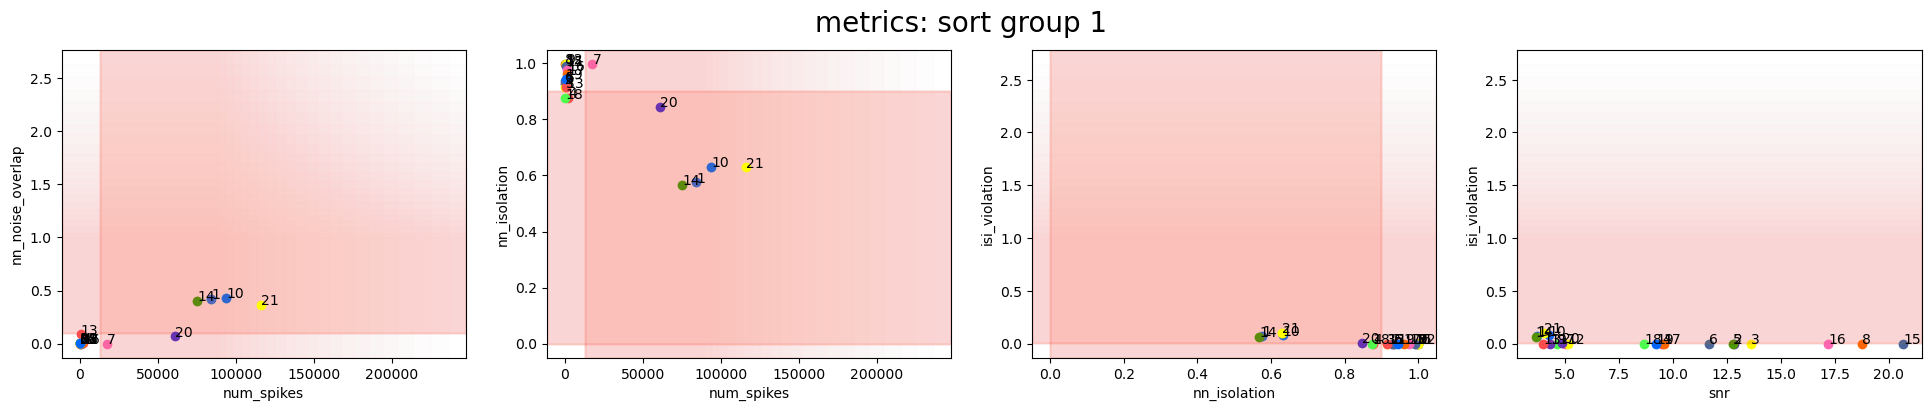

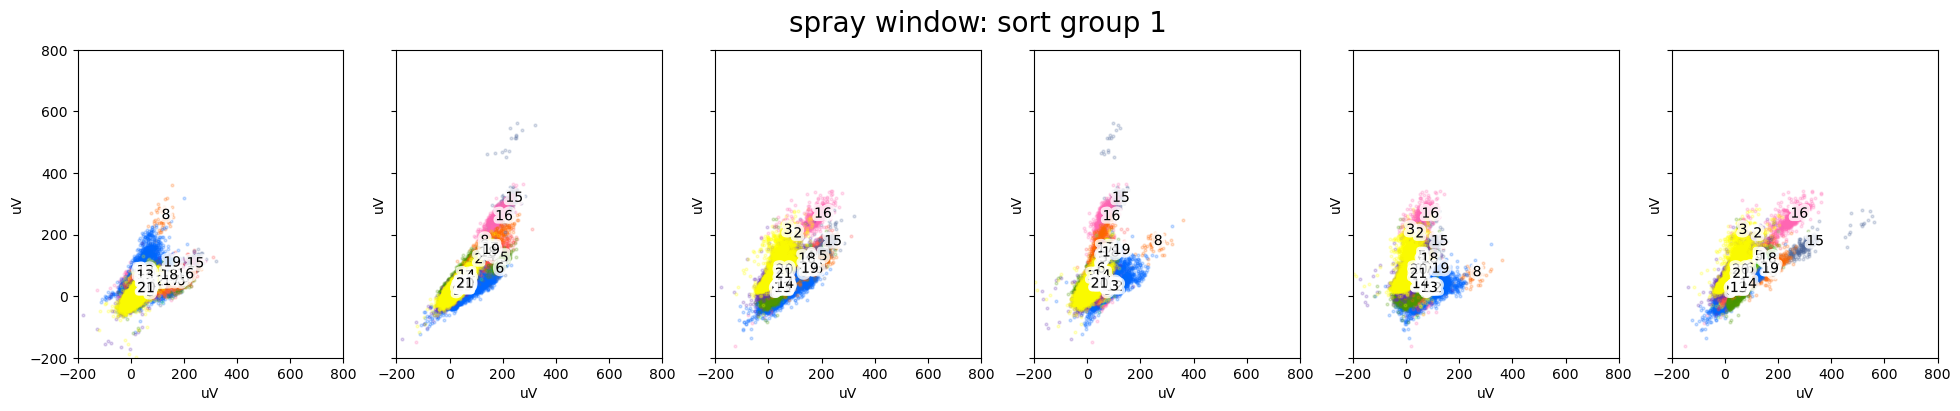

In [36]:
print("noise by spikeNum ", noiseUnits_spikeNum[sort_group_id])
print("noise by ISI ", noiseUnits_isi[sort_group_id])
show_plot(fig_m[sort_group_id], "metrics: sort group " + str(sort_group_id))
show_plot(fig_sp[sort_group_id], "spray window: sort group " + str(sort_group_id))

<div class="alert alert-block alert-info">  
    
### User input (box 4): Noise units
</div>

In [42]:
method = "B" #A for default, B for manual
if method == "A":
    noise_units = noiseUnits_spikeNum[sort_group_id]
else:
    noise_units = [1,7,9,10,11,12,13,14,20,21]

In [43]:
noise_units

[1, 7, 9, 10, 11, 12, 13, 14, 20, 21]

### Resume running cells

### Inspect waveforms to confirm:

0
1
2
3
4
5
6
7
8
9


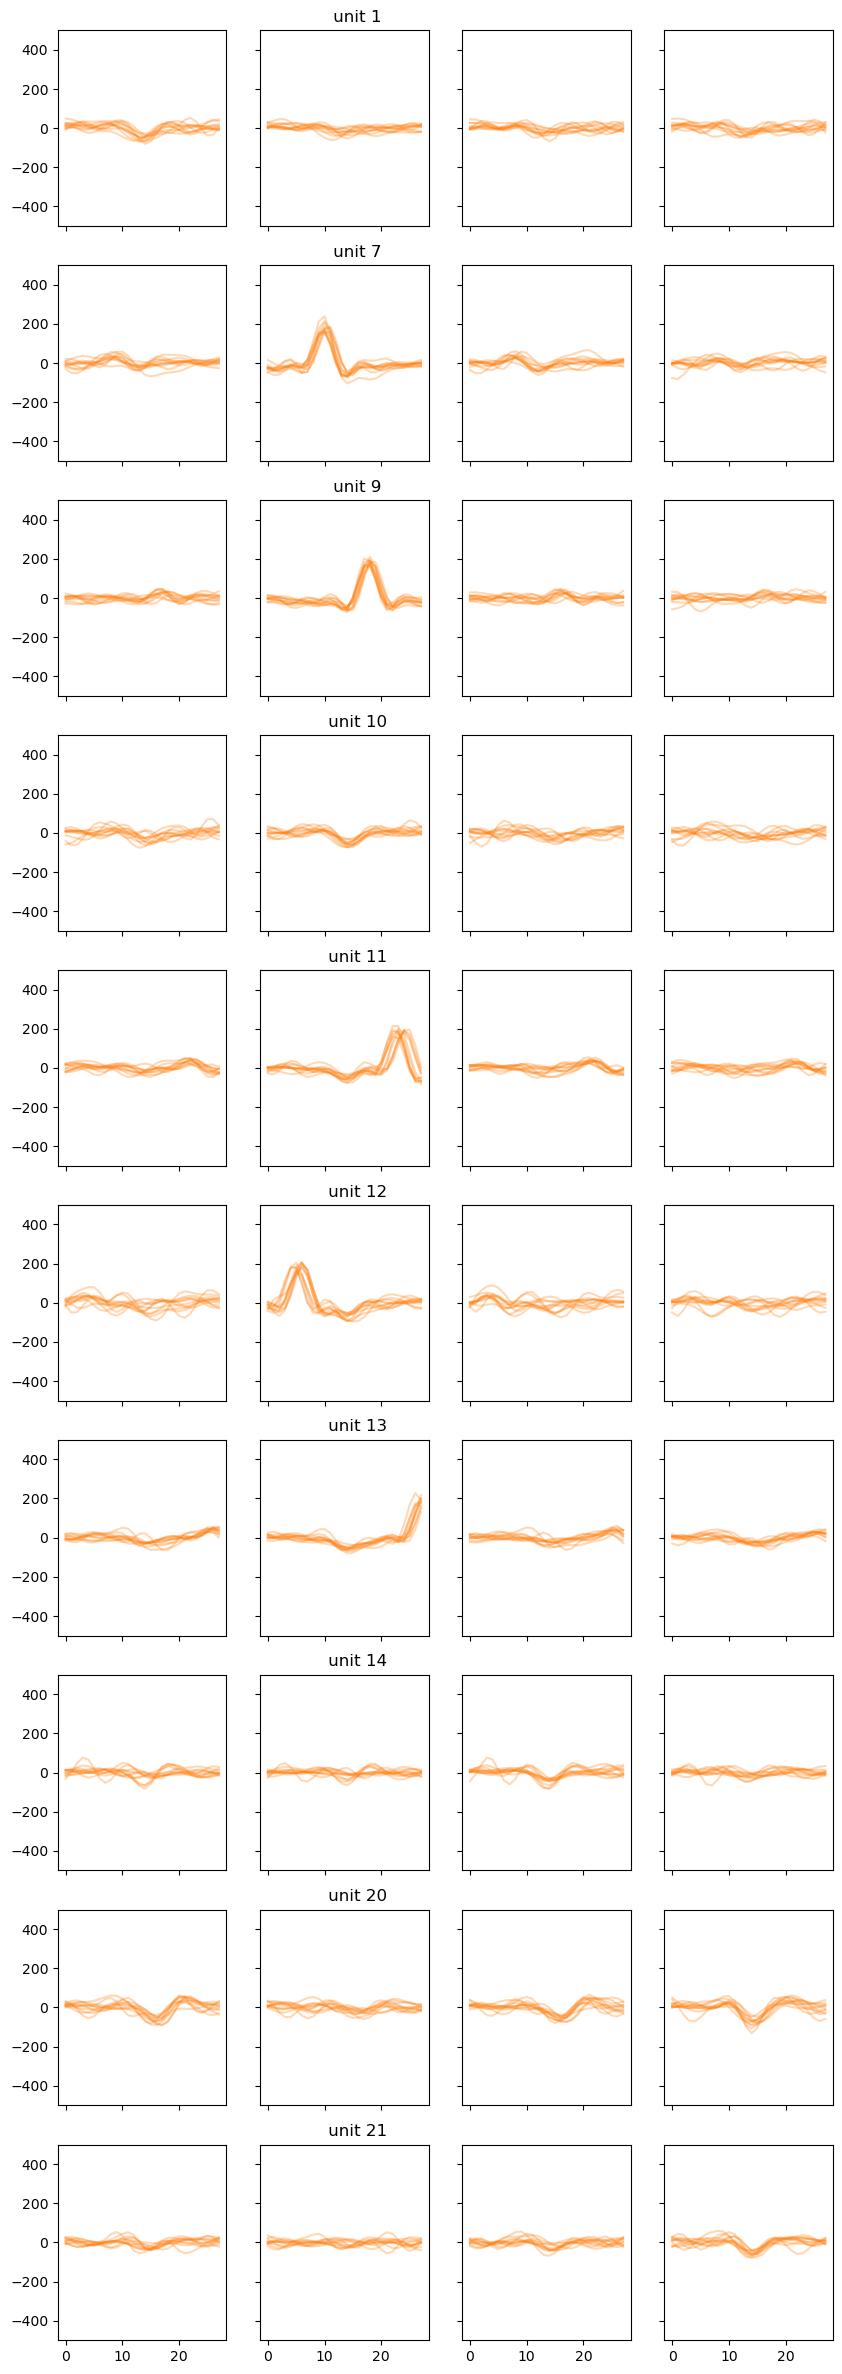

In [44]:
show_waveform(extractor,noise_units)

0
1
2
3
4
5
6
7
8
9
10


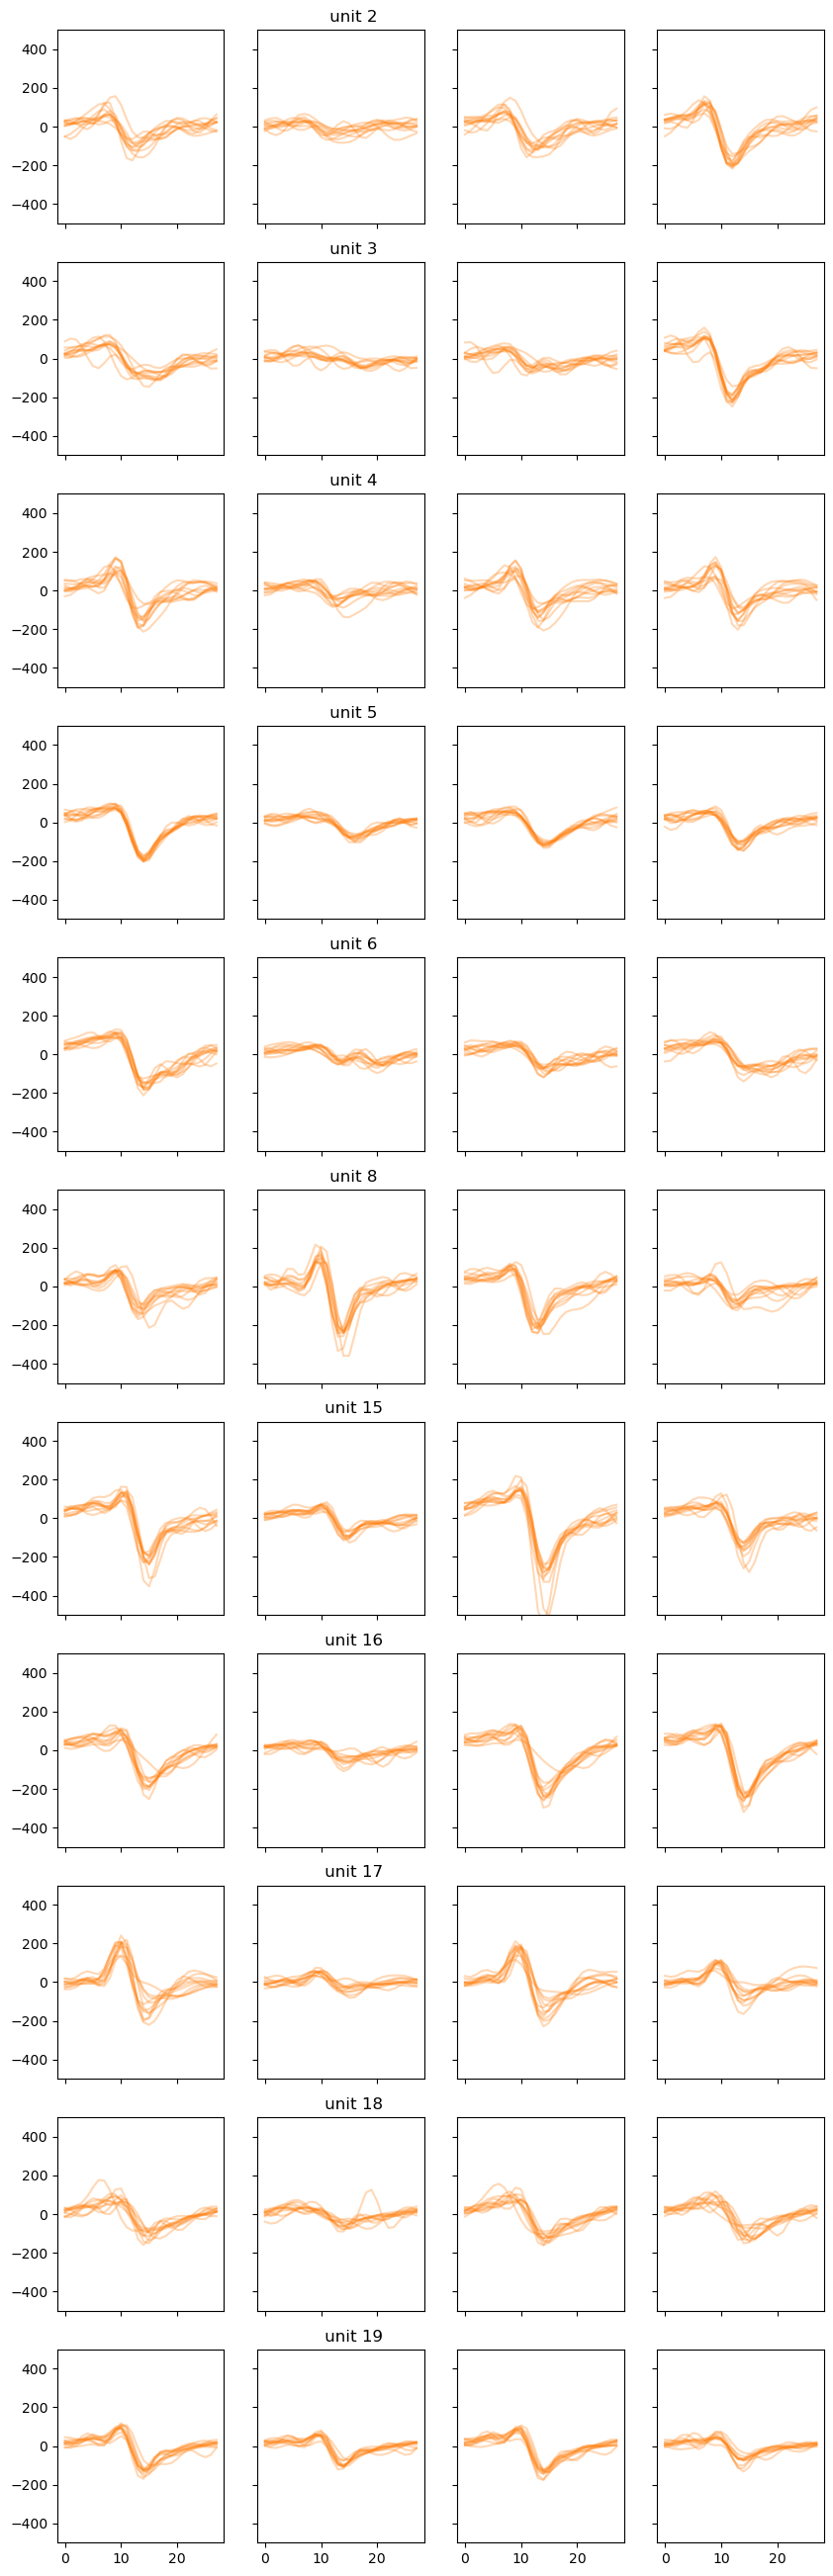

In [45]:
all_units = [int(u) for u in metrics[sort_group_id].index]
nonnoise_units = np.setdiff1d(all_units,noise_units)
show_waveform(extractor,nonnoise_units)

### MUA: Plot amplitude over time

In [46]:
fig_amp, axes_amp = plot_peak_amp_overtime(peak_amps,sort_group_id,nonnoise_units)

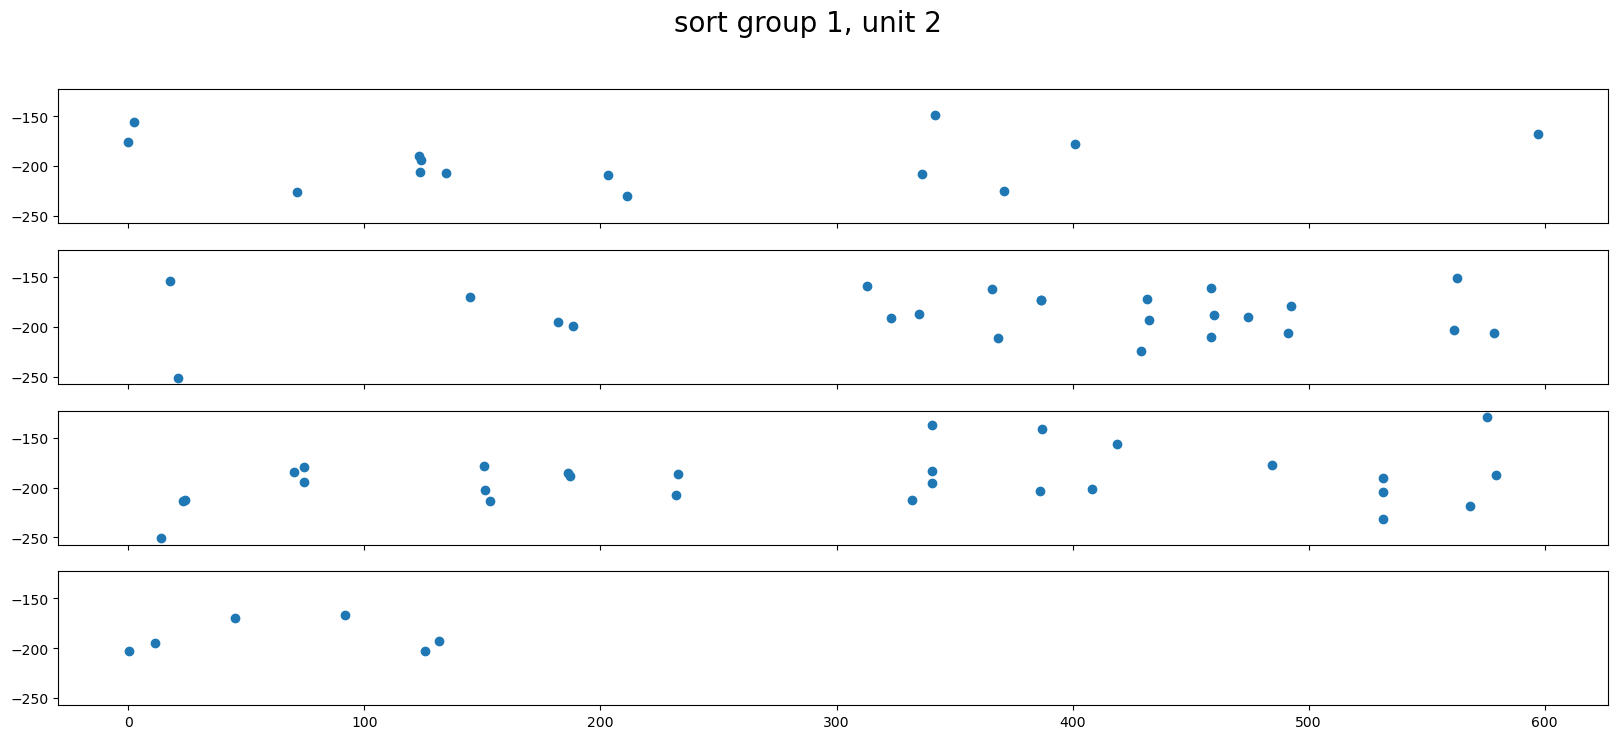

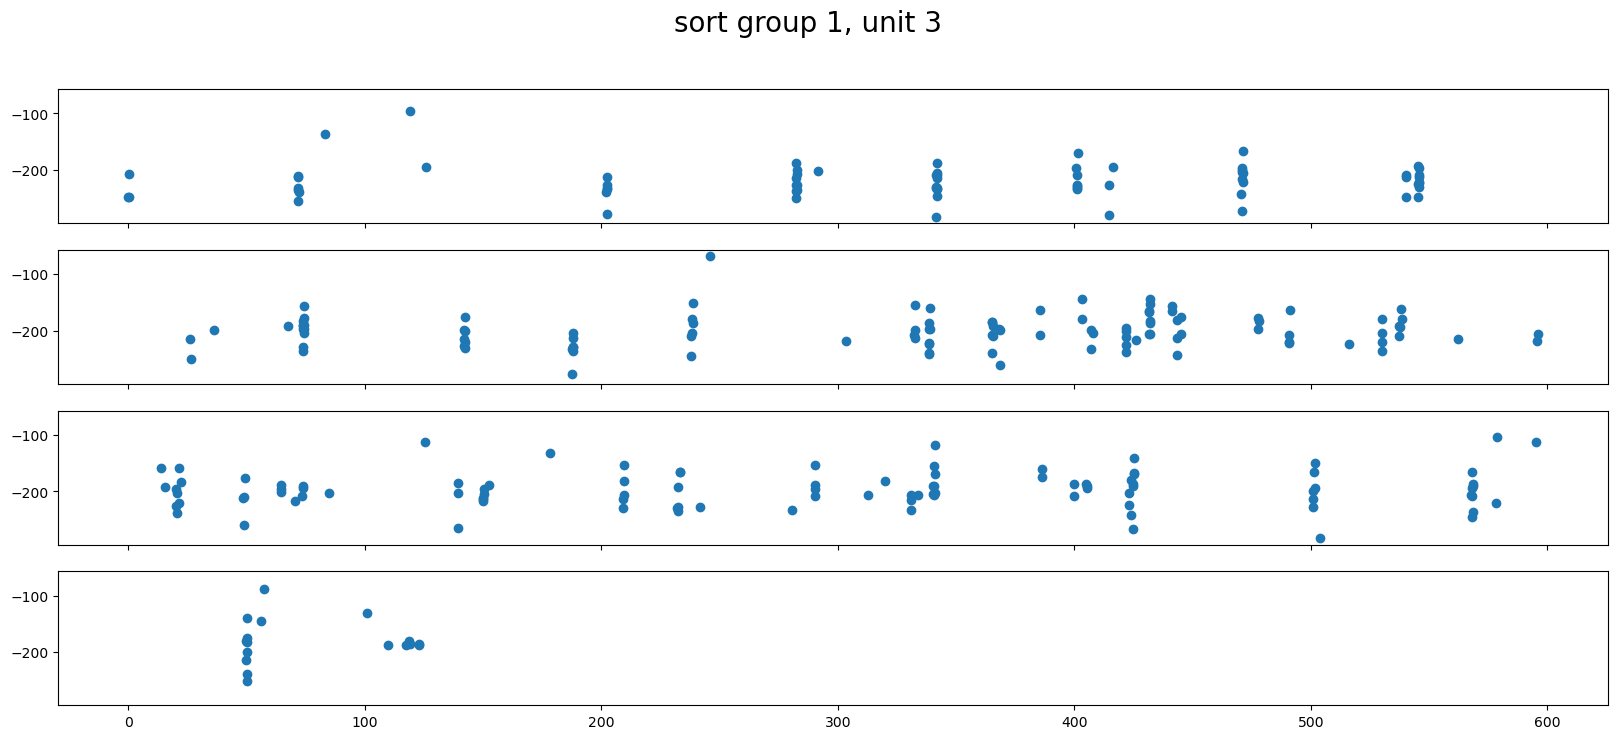

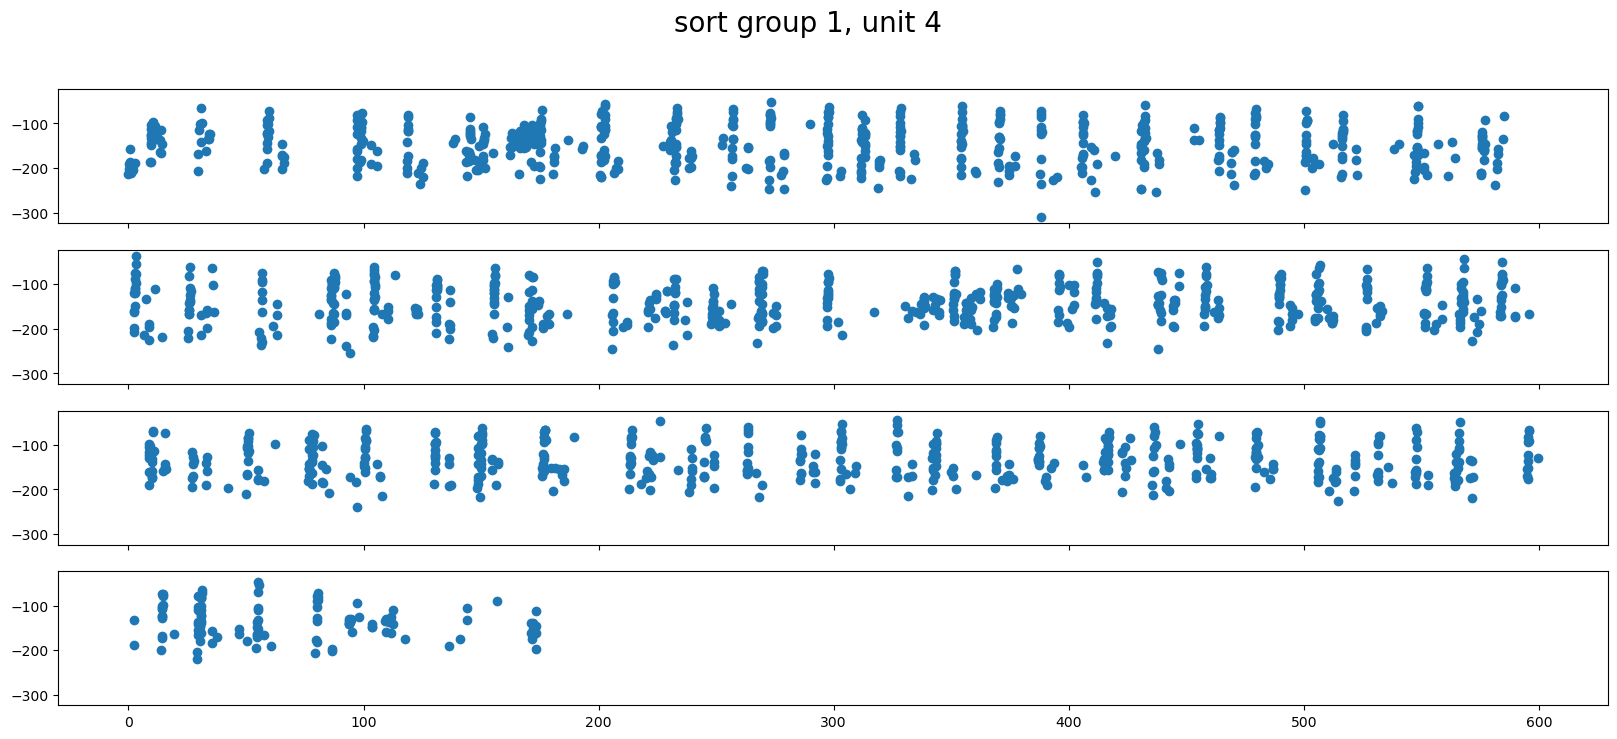

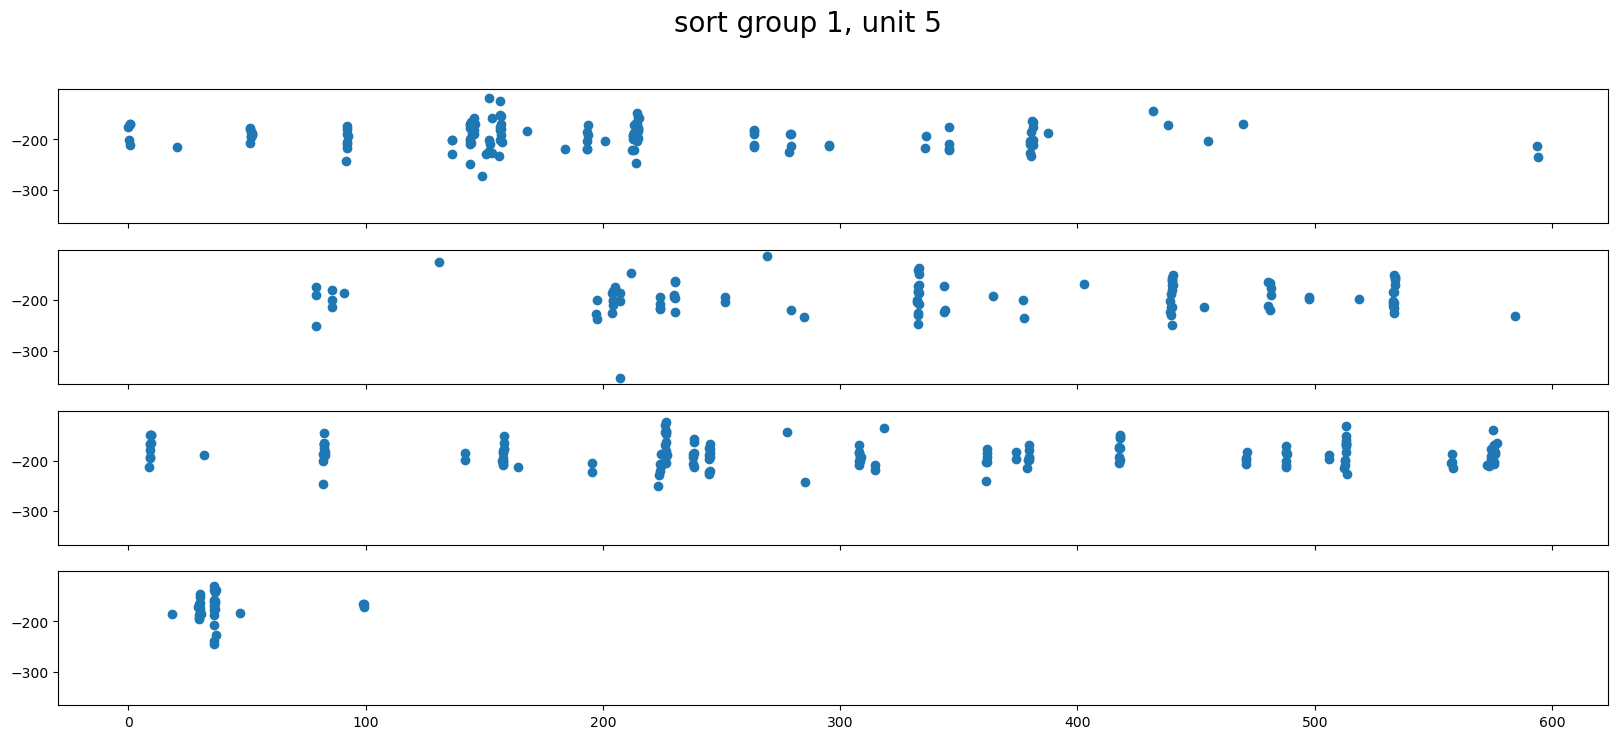

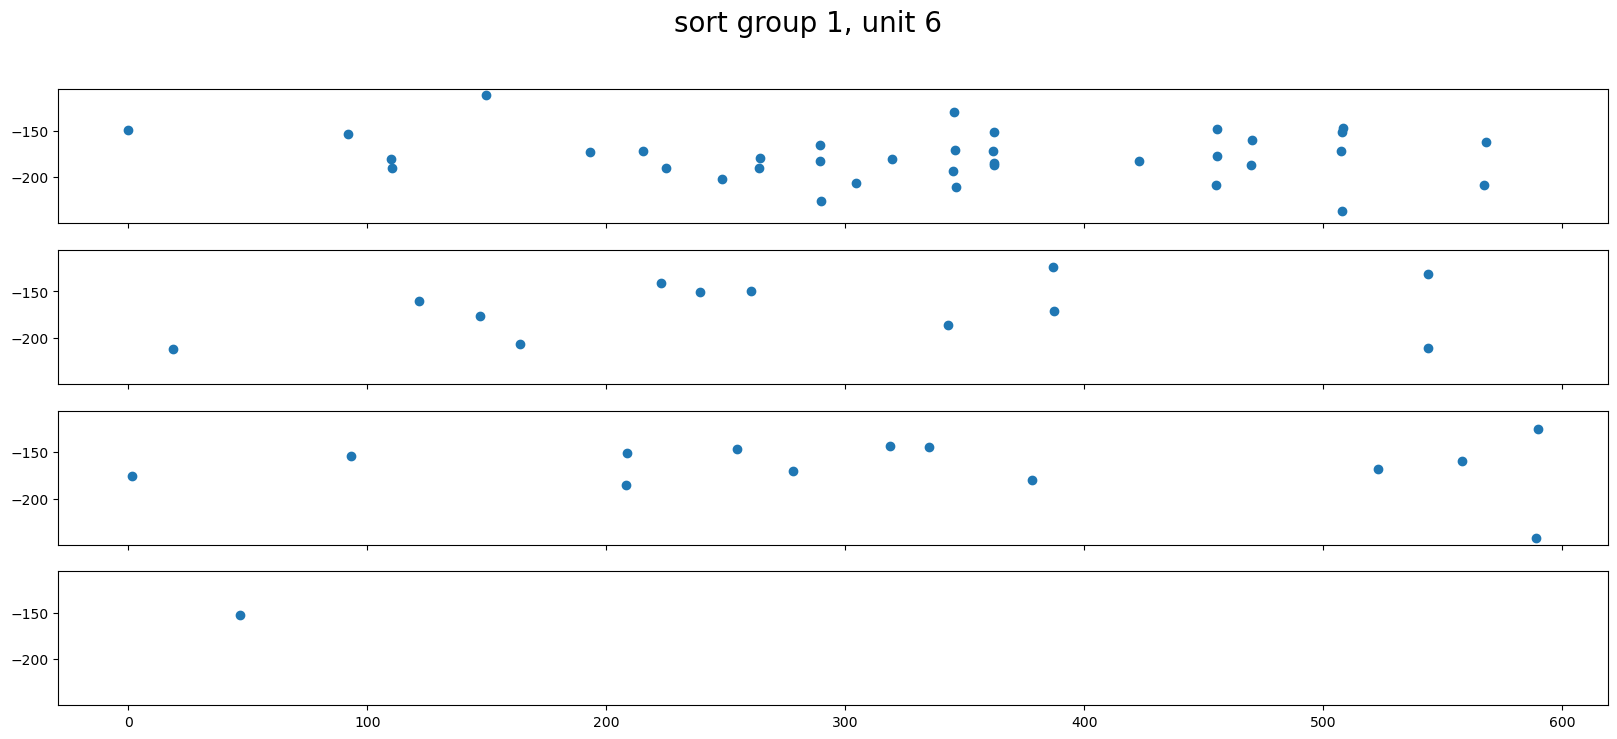

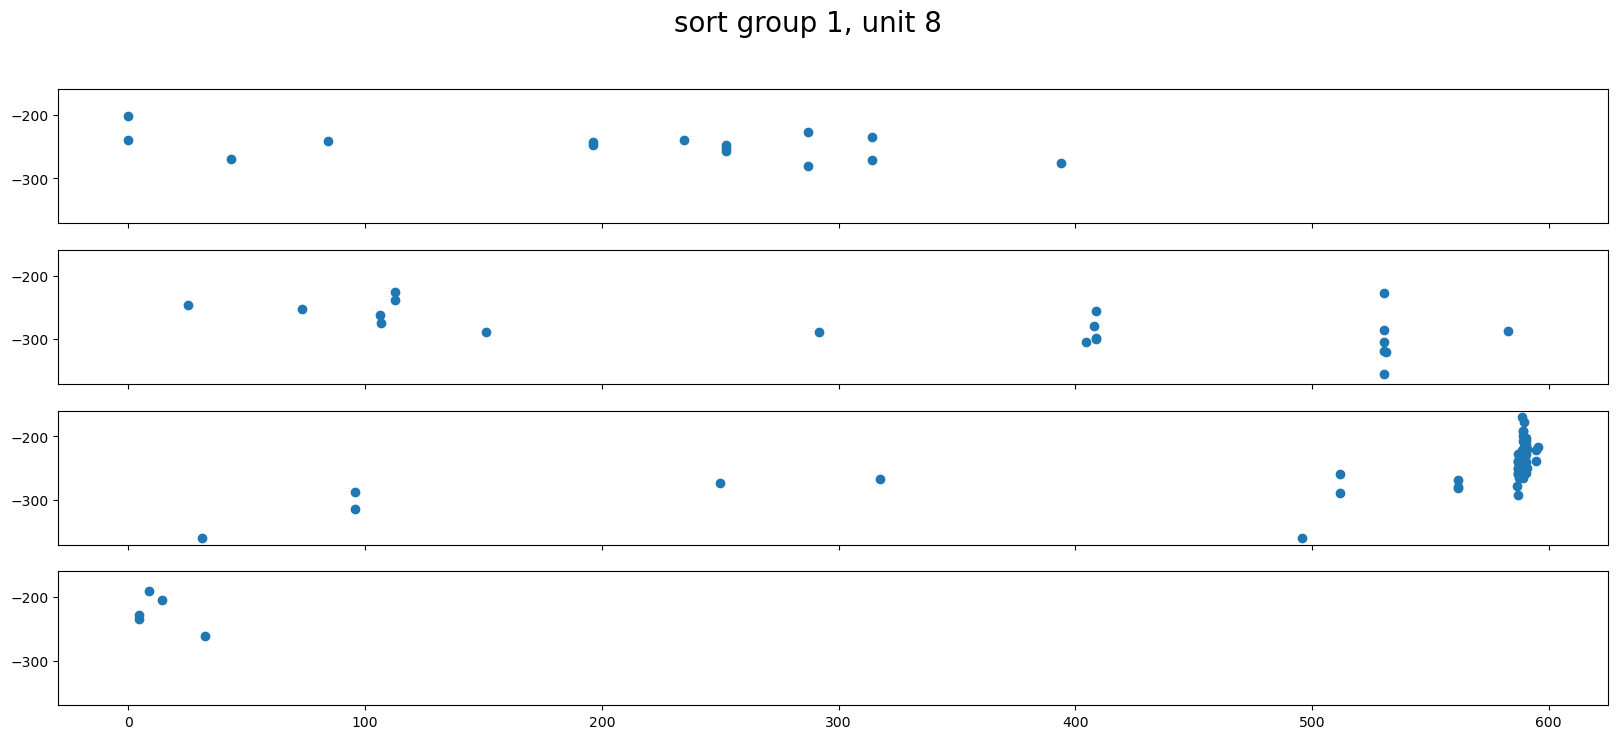

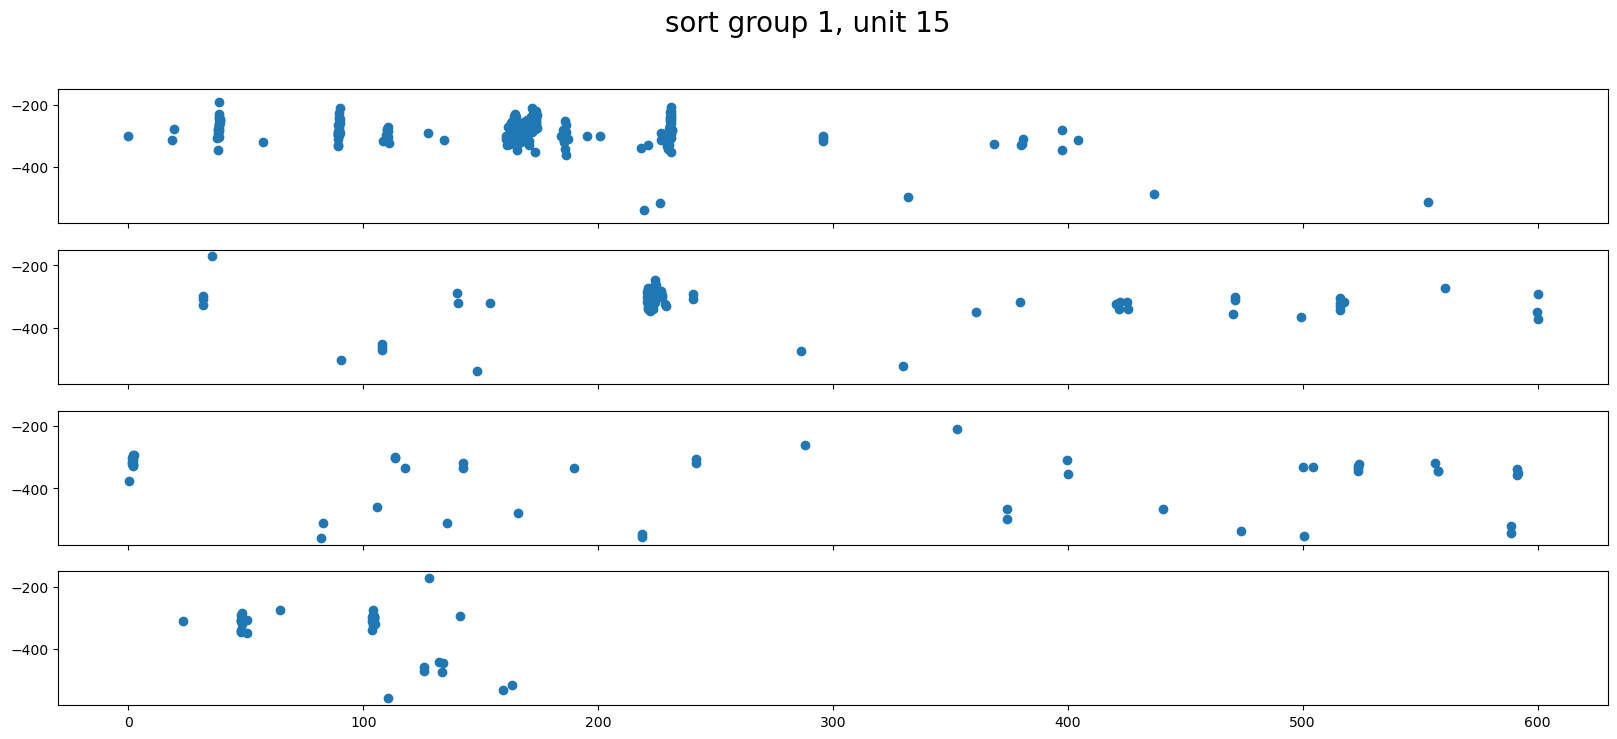

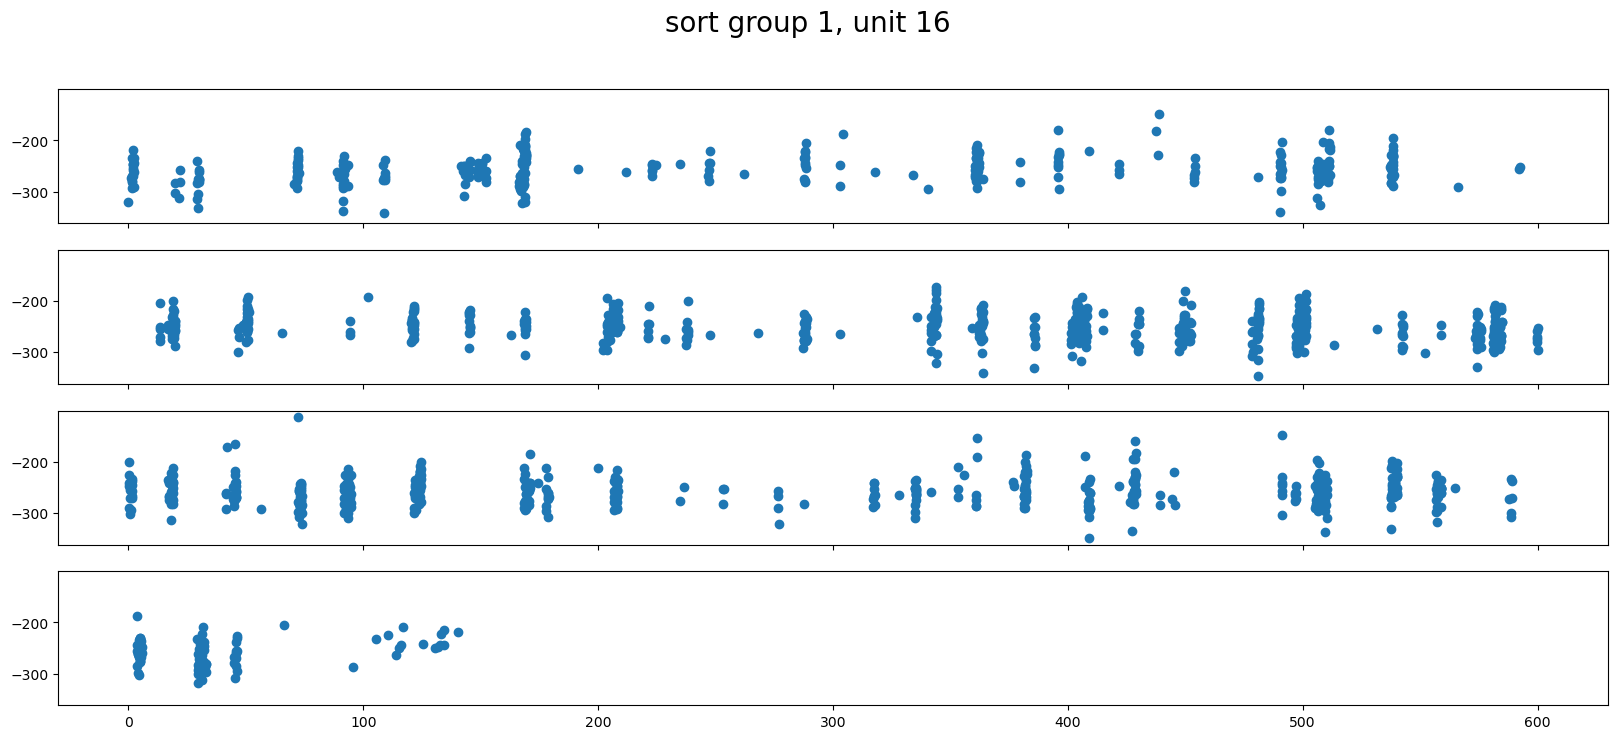

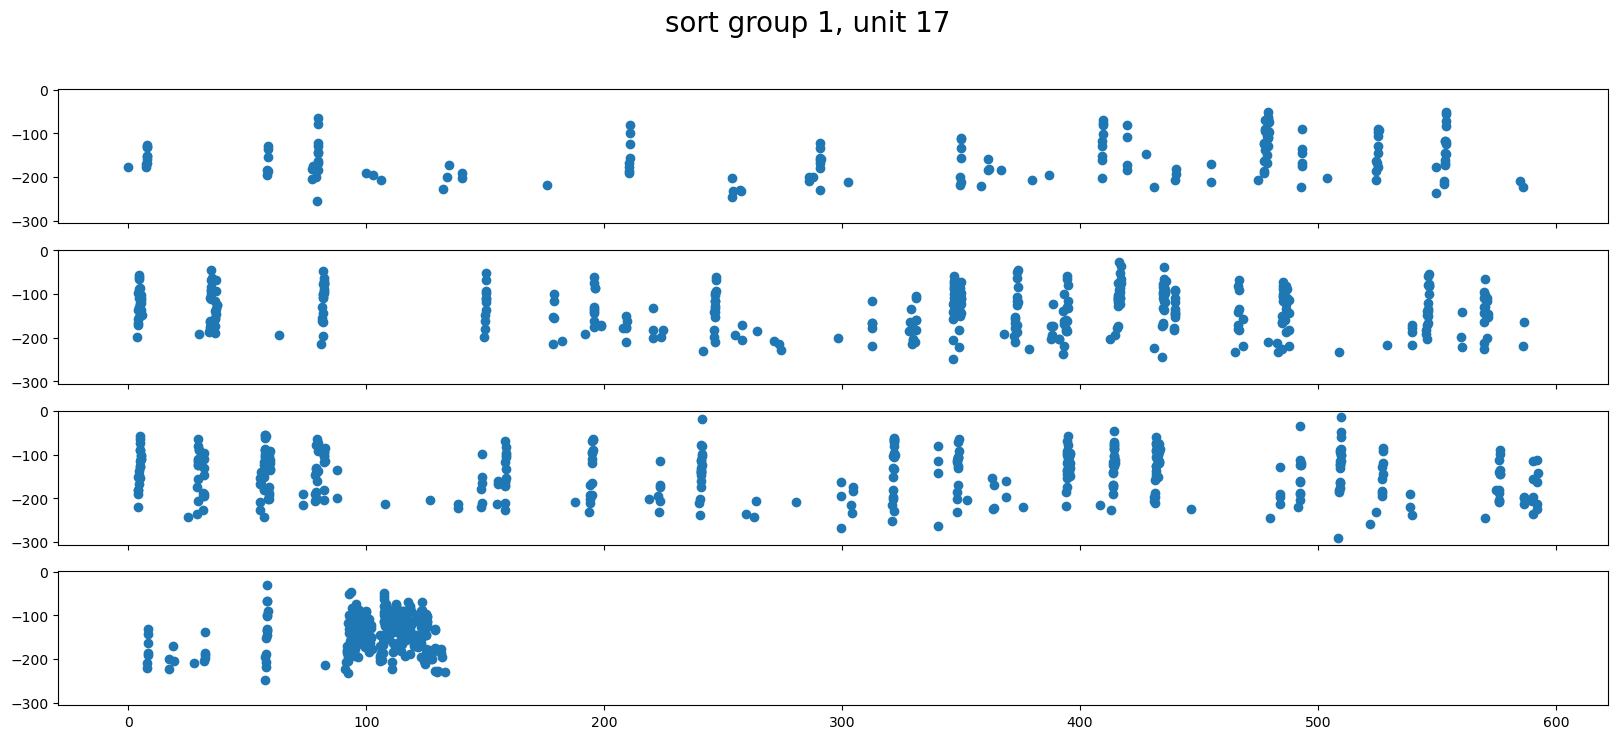

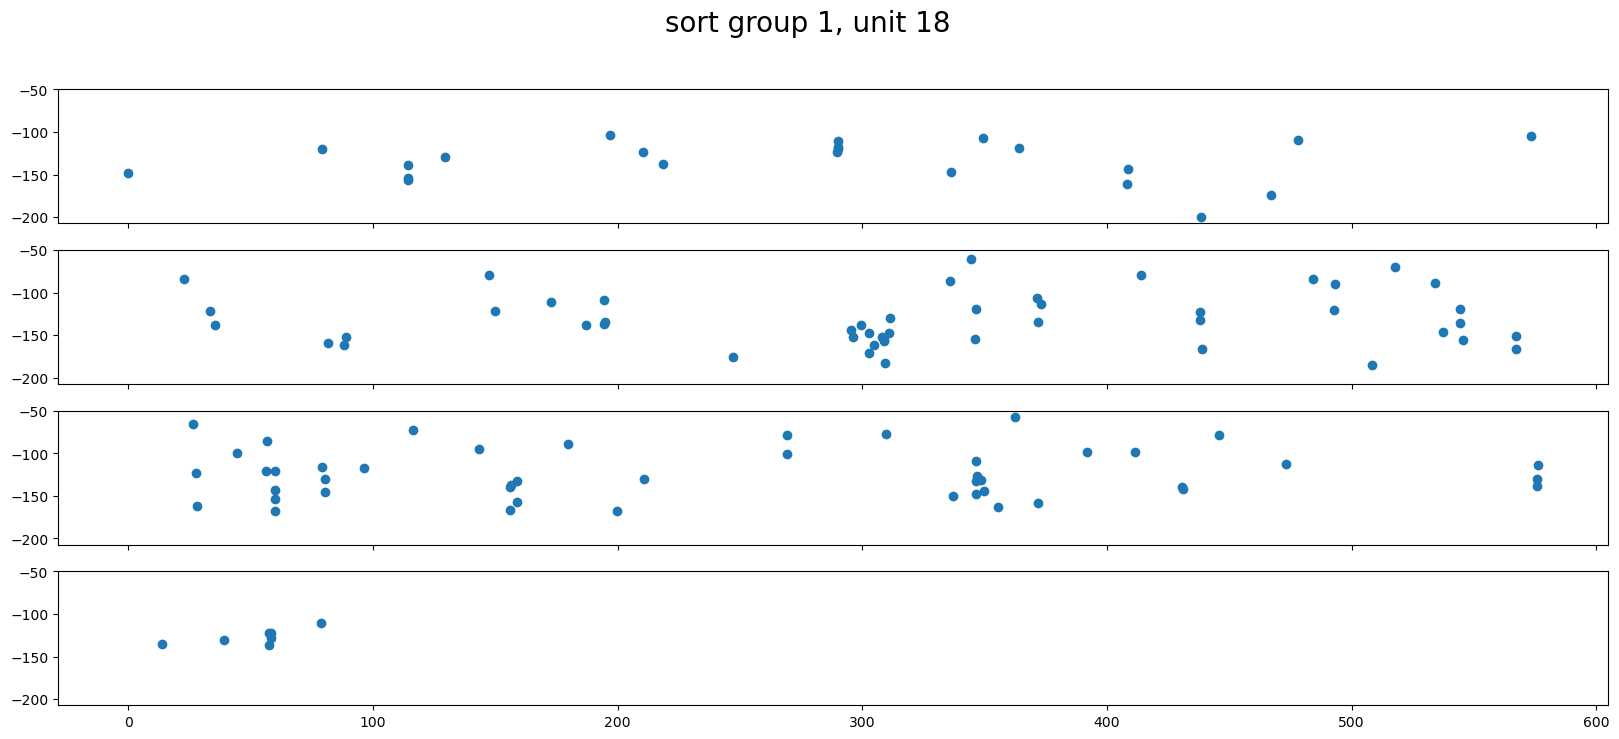

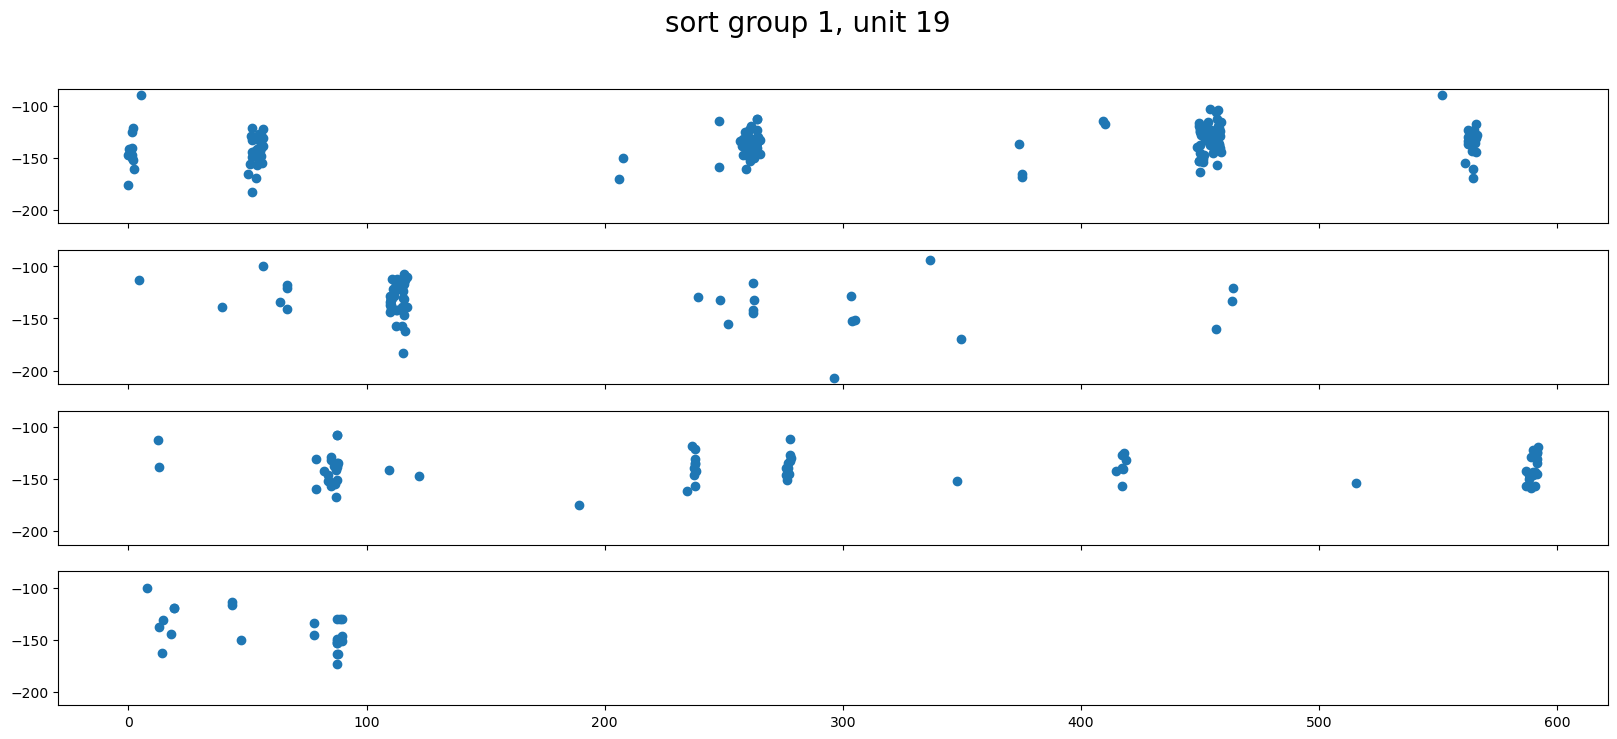

In [47]:
for u in nonnoise_units:
    show_plot(fig_amp[u], f"sort group {sort_group_id}, unit {u}")

<div class="alert alert-block alert-info">  
    
### User input (box 5): MUA units
</div>

In [48]:
mua_unit = []

### Once noise units are finalized, insert into CuratedSpikeSorting

Confirm these are the good cells by looking at their waveforms again
Sort Group ID 1
0
1
2
3
4
5
6
7
8
9
10


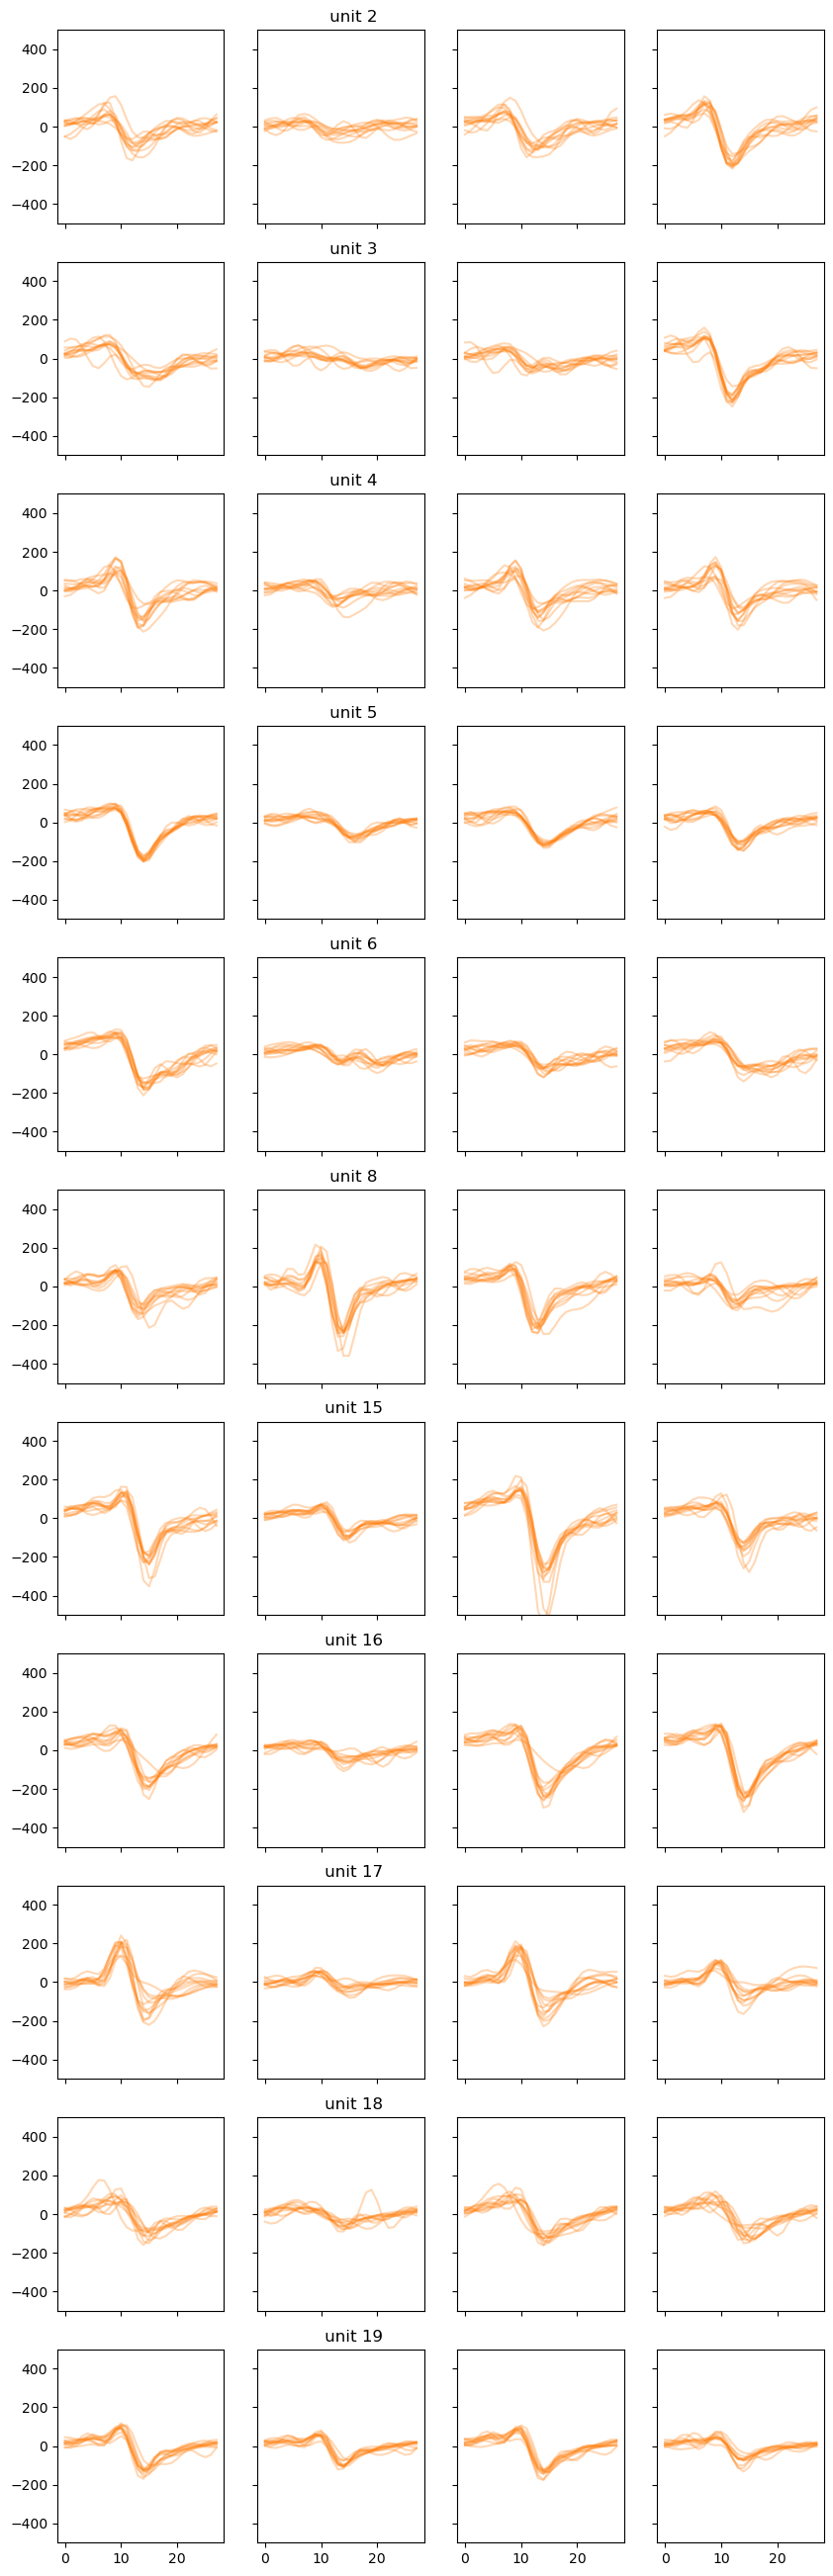

In [49]:
print("Confirm these are the good cells by looking at their waveforms again")
print(f"Sort Group ID {sort_group_id}")

good_units = np.setdiff1d(np.setdiff1d(nonnoise_units,noise_units),mua_unit)
show_waveform(extractor,good_units)

In [64]:
key = insert_CuratedSpikeSorting(nwb_copy_file_name, session_name, sort_group_id,
                           metrics[sort_group_id],
                           parent_curation_id, nonnoise_units, noise_units, mua_unit)

[13:52:39][INFO] Spyglass: Found 11 accepted units
[13:52:40][INFO] Spyglass: Writing new NWB file haydn20230604_HP5SLFKZV2.nwb
[13:52:41][INFO] Spyglass: Adding metric snr : [12.84996605 13.63303757  9.51227379 12.79143429 11.65017796 18.77256203
 20.66732597 17.1926403   9.56279659  8.67208958  9.22888088]
[13:52:41][INFO] Spyglass: Adding metric isi_violation : [0.         0.         0.00056148 0.         0.         0.
 0.         0.         0.         0.         0.        ]
[13:52:41][INFO] Spyglass: Adding metric nn_isolation : [0.92777778 0.91527778 0.87822581 0.93387097 0.93548387 0.99901961
 0.99109131 0.97580645 0.96129032 0.87580645 0.94435484]
[13:52:41][INFO] Spyglass: Adding metric nn_noise_overlap : [0.00416667 0.004811   0.0059     0.00332542 0.00322581 0.
 0.00022272 0.0009     0.0036     0.00080645 0.00846395]
[13:52:41][INFO] Spyglass: Adding metric peak_channel : [7. 7. 4. 4. 4. 5. 6. 7. 6. 6. 6.]
[13:52:41][INFO] Spyglass: Adding metric num_spikes : [  72.  291. 178

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[13:52:48][INFO] Spyglass: Writing new NWB file haydn20230604_U01MXTMX24.nwb


In [69]:
(sgs.Curation() & key)#.delete()

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,parent_curation_id,curation_labels a dictionary of labels for the units,merge_groups a list of merge groups for the units,quality_metrics a list of quality metrics for the units (if available),description optional description for this curated sort,"time_of_creation in Unix time, to the nearest second"
1,haydn20230604_.nwb,1,02_Rev3Session1,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,haydn20230604_.nwb_02_Rev3Session1_1_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,0,=BLOB=,=BLOB=,=BLOB=,"removal of noise units ONLY, by SVM and manual inspection",1733435554


In [74]:
(sgs.Curation() & {"nwb_file_name":nwb_copy_file_name,"curation_id":1}).delete() #key

[14:07:45][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
haydn20230604_ Shijie Gu     
 (Total: 1)

[14:07:45][INFO] Spyglass: Building merge cache for curation.
	Found 1 downstream merge tables
[2024-12-05 14:07:46,070][INFO]: Deleting 11 rows from `spikesorting_curation`.`__curated_spike_sorting__unit`
[2024-12-05 14:07:46,092][INFO]: Deleting 1 rows from `spikesorting_curation`.`__curated_spike_sorting`
[2024-12-05 14:07:46,120][INFO]: Deleting 2 rows from `spikesorting_curation`.`curated_spike_sorting_selection`
[2024-12-05 14:07:46,192][INFO]: Deleting 1 rows from `spikesorting_curation`.`__waveforms`
[2024-12-05 14:07:46,212][INFO]: Deleting 1 rows from `spikesorting_curation`.`waveform_selection`
[2024-12-05 14:07:46,233][INFO]: Deleting 2 rows from `spikesorting_curation`.`curation`


Commit deletes? [yes, No]:  yes


[2024-12-05 14:07:50,565][INFO]: Deletes committed.


In [72]:
# check the target curation_id is now here.
sgs.CuratedSpikeSorting() & {"nwb_file_name":nwb_copy_file_name,"sort_group_id":2,"curation_id":1} #key

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,analysis_file_name name of the file,units_object_id


### at the end of the session, run this cell

In [76]:
end_of_session_check(nwb_copy_file_name,session_name,parent_curation_id)

02_Rev3Session1 missing sort group [ 1 11 12 15 16 20 22 24 30]


0

### at the end of the day, run this cell

In [352]:
end_of_day_check(nwb_copy_file_name,parent_curation_id)

02_Seq2Session1 missing sort group [13 16 17 20 23 26 27 28 29 30]
missing session ['02_Seq2Session1' '04_Seq2Session2' '06_Seq2Session3' '08_Seq2Session4'
 '10_Seq2Session5']


0

<div class="alert alert-block alert-warning">
    
### Extra, if you need to re-investigate an entry
</div>

In [ ]:
metrics_json = load_metric(nwb_copy_file_name,'02_Seq2Session1',0,0)
metrics_pd = pd.DataFrame(metrics_json)
metrics_pd

In [297]:
key = {"nwb_file_name": nwb_copy_file_name,
       "sort_group_id": sort_group_id,
       "sorter": "mountainsort4",
       "sort_interval_name": session_name,
       "curation_id":1}

In [310]:
session_valid_t = (IntervalList() & {"interval_list_name":
                   (sgs.SpikeSorting() & key).fetch1("artifact_removed_interval_list_name")}).fetch1("valid_times").ravel()

In [312]:
session_duration = session_valid_t[-1] - session_valid_t[0]

2236.7524552345276

In [281]:
(sgs.Curation() & key).fetch1("curation_labels")

{2: ['accept'],
 3: ['accept'],
 5: ['accept'],
 6: ['accept'],
 8: ['accept'],
 9: ['accept'],
 10: ['accept'],
 11: ['accept'],
 1: ['reject'],
 4: ['reject'],
 7: ['reject'],
 12: ['reject']}

<div class="alert alert-block alert-danger">
    
### Extra, if you need to delete an entry
</div>

In [52]:
key = {"nwb_file_name": nwb_copy_file_name,
       "sort_group_id": sort_group_id,
       "sorter": "mountainsort4",
       "sort_interval_name": session_name,
       "curation_id":1}

In [61]:
#(sgs.CuratedSpikeSorting() & key).delete()
#(sgs.Curation() & key).delete()

In [112]:
key = {'nwb_file_name': 'eliot20221016_.nwb',
 'sort_group_id': 4,
 'sort_interval_name': '02_Seq2Session1',
"curation_id":1}

In [109]:
key = {'curation_id': 1,
 'nwb_file_name': 'haydn20230604_.nwb',
 'sort_group_id': 20,
 'sort_interval_name': '02_Rev3Session1',
 'preproc_params_name': 'franklab_tetrode_hippocampus',
 'team_name': 'SequenceTask',
 'sorter': 'mountainsort4',
 'sorter_params_name': 'CA1_tet_Shijie'}

In [108]:
(sgs.Curation() & key).fetch1("artifact_removed_interval_list_name")

'haydn20230604_.nwb_02_Rev3Session1_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'

In [114]:
#(sgs.Curation() & key).delete()